In [1]:
import os
from osgeo import gdal, ogr, osr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import ListedColormap, BoundaryNorm
import xarray as xr
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
import random
from sklearn.model_selection import train_test_split
# import rioxarray as rxr
# import earthpy.plot as ep
# import cartopy.crs as ccrs

In [2]:
def scaleCCMinMax(x):
    return(x - np.nanpercentile(x, 2))/(np.nanpercentile(x, 98) - np.nanpercentile(x, 2))

### Read in all data & Visual check & Convert to table

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


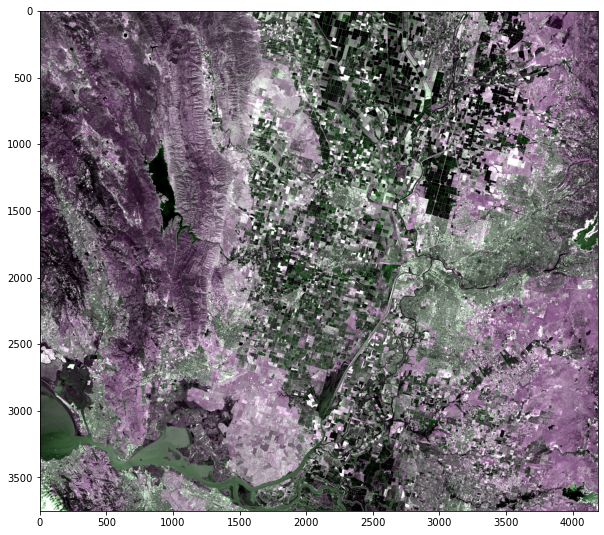

(3751, 4188, 7)
(7, 4188, 3751)
(15709188, 7)


In [34]:
raster_dir = '../data/Data'

for file in os.listdir(raster_dir):
    if file.endswith('SRB1_clip.tif'):
        raster = gdal.Open(os.path.join(raster_dir, file))
        CAerosol = raster.GetRasterBand(1).ReadAsArray()
    elif file.endswith('SRB2_clip.tif'):
        raster = gdal.Open(os.path.join(raster_dir, file))
        BLUE = raster.GetRasterBand(1).ReadAsArray()
    elif file.endswith('SRB3_clip.tif'):
        raster = gdal.Open(os.path.join(raster_dir, file))
        GREEN = raster.GetRasterBand(1).ReadAsArray()
    elif file.endswith('SRB4_clip.tif'):
        raster = gdal.Open(os.path.join(raster_dir, file))
        RED = raster.GetRasterBand(1).ReadAsArray()
    elif file.endswith('SRB5_clip.tif'):
        raster = gdal.Open(os.path.join(raster_dir, file))
        NIR = raster.GetRasterBand(1).ReadAsArray()
    elif file.endswith('SRB6_clip.tif'):
        raster = gdal.Open(os.path.join(raster_dir, file))
        SWIR1 = raster.GetRasterBand(1).ReadAsArray()
    elif file.endswith('SRB7_clip.tif'):
        raster = gdal.Open(os.path.join(raster_dir, file))
        SWIR2 = raster.GetRasterBand(1).ReadAsArray()

raster_array = np.dstack((CAerosol, BLUE, GREEN, RED, NIR, SWIR1, SWIR2))/10000
Image_Pre_Check = np.dstack((scaleCCMinMax(raster_array[:, :, 3]), scaleCCMinMax(raster_array[:, :, 2]), scaleCCMinMax(raster_array[:, :, 3])))
plt.figure(figsize=(10, 10))
plt.imshow(Image_Pre_Check)
# plt.savefig('../results/Image_Pre_Check.png')
plt.show()

# fig = plt.figure(figsize=(10, 10))
# ax = fig.add_subplot(111, projection=raster.GetProjection())
# ax.imshow(Image_Pre_Check)
# plt.show()

print(raster_array.shape)

raster_array_t = raster_array.transpose()
print(raster_array_t.shape)

raster_array_table = raster_array_t.reshape(raster_array_t.shape[0], (raster_array_t.shape[1]*raster_array_t.shape[2])).transpose()
print(raster_array_table.shape)

(7, 15709188)
(3751, 4188, 7)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


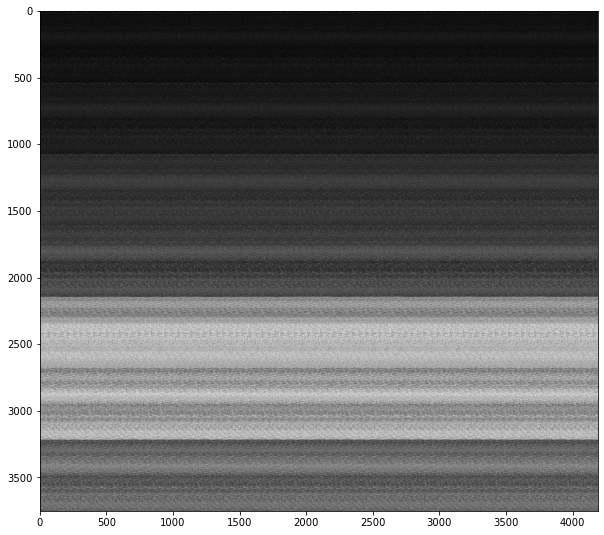

In [36]:
result_array_t = raster_array_table.transpose()
print(result_array_t.shape)

result_array = result_array_t.reshape(raster_array_t.shape[2], raster_array_t.shape[1], raster_array_t.shape[0])
print(result_array.shape)

Result_Check = np.dstack((scaleCCMinMax(result_array[:, :, 3]), scaleCCMinMax(result_array[:, :, 2]), scaleCCMinMax(result_array[:, :, 3])))

plt.figure(figsize=(10, 10))
plt.imshow(Result_Check)
# plt.savefig('../results/Image_Pre_Check.png')
plt.show()

### Prepare Training label

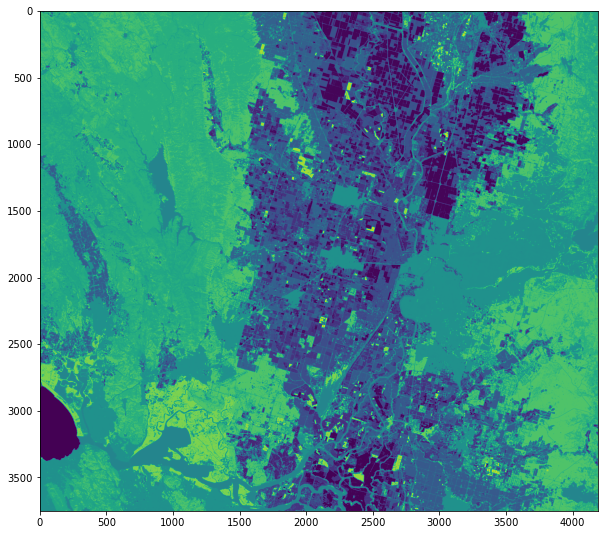

(3751, 4188)
(15709188, 1)


In [4]:
groundTruth_path = '../data/GroundTruth/CDL_2021_06_clip.tif'

raster = gdal.Open(groundTruth_path)
groundTruth = raster.GetRasterBand(1).ReadAsArray()

plt.figure(figsize=(10, 10))
plt.imshow(groundTruth)
plt.show()

print(groundTruth.shape)

groundTruth_table = groundTruth.reshape(1, (groundTruth.shape[0]*groundTruth.shape[1])).transpose()
print(groundTruth_table.shape)

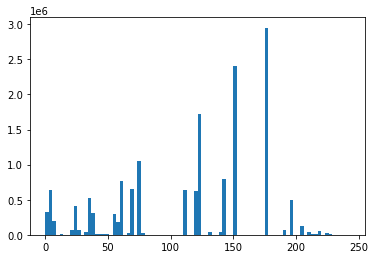

[  0   1   2   3   4   5   6  12  13  14  21  22  23  24  27  28  29  31
  33  36  37  39  42  43  44  46  47  48  49  50  51  53  54  57  58  59
  61  66  67  68  69  70  71  72  74  75  76  77  92 111 112 121 122 123
 124 131 141 142 143 152 176 190 195 204 205 206 208 209 211 212 213 214
 216 217 218 219 220 221 222 224 225 226 227 228 229 236 242 243]
88


In [6]:
plt.figure()
plt.hist(groundTruth.flatten(), bins = 86)
plt.show()

print(np.unique(groundTruth.flatten()))
print(len(np.unique(groundTruth.flatten())))

In [8]:
groundTruth_df = pd.DataFrame(groundTruth_table)
table = pd.DataFrame(groundTruth_df.groupby([0]).size())

0
0          
0    117934
1    209832
2      1348
3    631669
4      2207
..      ...
228    4356
229     423
236    1138
242       9
243     104

[88 rows x 1 columns]

In [12]:
groundTruth_df = pd.DataFrame(groundTruth_table)
table = pd.DataFrame(groundTruth_df.groupby([0]).size())

table['groundType'] = ['Water', 'Corn', 'Cotton', 'Rice', 'Sorghum', 'Soybeans', 'unflower', 'Sweet Corn', 'Pop or Orn Corn', 'Mint', 'Barley', 'Durum Wheat', 'Spring Wheat', 'Winter Wheat', 'Rye', 'Oats', 'Millet', 'Canola', 'Safflower', 'Alfalfa', 
                       'Other Hay/Non Alfalfa', 'Buckwheat', 'Sugarbeets', 'Botatoes', 'Other Crops', 'Sweet Potatoes', 'Misc Vegs & Fruits', 'Watermelons', 'Onions', 'Cucumbers', 'Chick Peas', 'Peas', 'Tomatoes', 'Herbs', 'Clover/Wildflowers', 
                       'Sod/grass Seed', 'Fllow/Idle Cropland', 'Cherries', 'Peaches', 'Apples', 'Grapes', 'Christmas Trees', 'Other Tree Crops', 'Citrus', 'Pecans', 'Almonds', 'Walnuts', 'Pears', 'Aquaculture', 'Open Water', 'Perennial Ice/Snow', 
                       'Developed/Open Space', 'Developed/Low Intensity', 'Developed/Med Intensity', 'Developed/High Intensity', 'Barren', 'Decodipis Forest', 'Evergreen Forest', 'Mixed Forest', 'Shrubland', 'Grassland/Pasture', 'Woody Wetlands', 
                       'Herbaceous Wetlands', 'Pistachios', 'Triticale', 'Carrots', 'Garlic', 'Cantaloupes', 'Olives', 'Oranges', 'Honeydew Meions', 'Broccoli', 'Peppers', 'Pomegranates', 'Nectarines', 'Greens', 'Plums', 'Strawberries', 'Squash', 'Vetch', 
                       'Dbl Crop WinWht/Corn', 'Dbi Crop Oats/Corn', 'Lettuce', 'Dbl Crop Triticale/Corn', 'Pumpkins', 'Dbl Crop Winwht/Sorghum', 'Blueberries', 'Cabbage']
table['reclassify'] = ['Water', 'Corn', 'Other Crops', 'Rice', 'Wheat', 'GroundVege', 'Flower', 'Corn', 'Corn', 'Alfalfa', 'Wheat', 'Wheat', 'Wheat', 'Wheat', 'Wheat', 'Wheat', 'Wheat', 'Flower', 'Flower', 'Alfalfa', 'Hay', 'Wheat', 'Tuber', 'Tuber', 'Other Crops', 'Tuber', 
                       'Other Crops', 'GroundVege', 'GroundVege', 'GroundVege', 'Wheat', 'GroundVege', 'GroundVege', 'Alfalfa', 'Flower', 'Grassland', 'Idle cropland', 'FruitsTree', 'FruitsTree', 'FruitsTree', 'Grapes', 'FruitsTree', 'FruitsTree', 'FruitsTree', 'NutTree', 
                       'NutTree', 'NutTree', 'FruitsTree', 'Water', 'Water', 'Water', 'Urban', 'Urban', 'Urban', 'Urban', 'Barren', 'Forest', 'Forest', 'Forest', 'Shrubland', 'Grassland', 'Wetland', 'Wetland', 'NutTree', 'Wheat', 'GroundVege', 'GroundVege', 'GroundVege', 
                       'NutTree', 'FruitsTree', 'GroundVege', 'GroundVege', 'GroundVege', 'FruitsTree', 'FruitsTree', 'GroundVege', 'FruitsTree', 'Other Crops', 'GroundVege', 'Flower', 'Corn', 'Corn', 'GroundVege', 'Corn', 'GroundVege', 'Wheat', 'GroundVege', 'GroundVege']
table['NewValue'] = [2, 18, 20, 17, 16, 12, 15, 18, 18, 14, 16, 16, 16, 16, 16, 16, 16, 15, 15, 14, 6, 16, 13, 13, 20, 13, 20, 12, 12, 12, 16, 12, 12, 14, 15, 5, 19, 10, 10, 10, 9, 10, 10, 10, 11, 11, 11, 10, 2, 2, 2, 3, 3, 3, 3, 1, 8, 8, 8, 7, 5, 4, 4, 11, 
                     16, 12, 12, 12, 11, 10, 12, 12, 12, 10, 10, 12, 10, 20, 12, 15, 18, 18, 12, 18, 12, 16, 12, 12]

table.to_csv('../data/GroundTruth/LandCover.csv')
table

0               groundType   reclassify  NewValue
0                                                          
0    117934                    Water        Water         2
1    209832                     Corn         Corn        18
2      1348                   Cotton  Other Crops        20
3    631669                     Rice         Rice        17
4      2207                  Sorghum        Wheat        16
..      ...                      ...          ...       ...
228    4356  Dbl Crop Triticale/Corn         Corn        18
229     423                 Pumpkins   GroundVege        12
236    1138  Dbl Crop Winwht/Sorghum        Wheat        16
242       9              Blueberries   GroundVege        12
243     104                  Cabbage   GroundVege        12

[88 rows x 4 columns]

In [13]:
for index, row in table.iterrows():
    # print(groundTruth_table == index)
    groundTruth_table[groundTruth_table == index] = row['NewValue']

In [14]:
groundTruth_table = pd.DataFrame(groundTruth_table)
groundTruth_table.shape

(15709188, 1)

In [16]:
reclass_table = pd.DataFrame(groundTruth_table.groupby([0]).size())
reclass_table['Class'] = ['Barren', 'Water', 'Urban', 'Wetland', 'Grassland', 'Hay', 'Shrubland', 'Forest', 'Grapes', 'FruitsTree', 'NutTree', 'GroundVege', 'Tuber', 'Alfalfa', 'Flower', 'Wheat', 'Rice', 'Corn', 'Idle cropland', 'Other Crops']

reclass_table['percentile'] = reclass_table[0] / np.sum(reclass_table[0])

print(np.sum(reclass_table['percentile']))
reclass_table['sample_size'] = np.round(reclass_table['percentile'] * 600000)
print(np.sum(reclass_table['sample_size']))
reclass_table

1.0
600002.0


0          Class  percentile  sample_size
0                                                  
1     41254         Barren    0.002626       1576.0
2    644420          Water    0.041022      24613.0
3   2347088          Urban    0.149409      89645.0
4    565302        Wetland    0.035985      21591.0
5   2950765      Grassland    0.187837     112702.0
6    308647            Hay    0.019648      11789.0
7   2410539      Shrubland    0.153448      92069.0
8    831074         Forest    0.052904      31742.0
9    644888         Grapes    0.041052      24631.0
10   115825     FruitsTree    0.007373       4424.0
11  1107766        NutTree    0.070517      42310.0
12   338271     GroundVege    0.021533      12920.0
13    17529          Tuber    0.001116        670.0
14   522879        Alfalfa    0.033285      19971.0
15   432938         Flower    0.027560      16536.0
16   654523          Wheat    0.041665      24999.0
17   631669           Rice    0.040210      24126.0
18   241755           Corn    0.015389       9234.0
19   771604  Idle cropland    0.049118      29471.0
20   130452    Other Crops    0.008304       4983.0

In [17]:
label_index = []
for index, row in reclass_table.iterrows():
    label_index.extend(groundTruth_table[groundTruth_table==index].sample(n=int(row['sample_size']), replace=False).index)
print('Random selected label index shape: ' + str(pd.DataFrame(label_index).shape))

data = raster_array_table[label_index, :]
print('Training data input shape: ' + str(data.shape))
label = np.array(groundTruth_table)[label_index]
print('Training data label shape: ' + str(label.shape))

x_train,x_test,y_train,y_test = train_test_split(data, label, test_size=0.33, random_state=208)

print('Training data input shape: ' + str(x_train.shape))
print('Training data label shape: ' + str(y_train.shape))
print('Testing data input shape: ' + str(x_test.shape))
print('Testing data label shape: ' + str(y_test.shape))

Random selected label index shape: (600002, 1)
Training data input shape: (600002, 7)
Training data label shape: (600002, 1)
Training data input shape: (402001, 7)
Training data label shape: (402001, 1)
Testing data input shape: (198001, 7)
Testing data label shape: (198001, 1)


### Apply Machine Learning Method

In [18]:
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import metrics
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [20]:
rfc = RandomForestClassifier()
rfc.fit(x_train,y_train)

pred = rfc.predict(x_test)
print(metrics.classification_report(pred,y_test))

              precision    recall  f1-score   support

           1       0.03      0.47      0.06        34
           2       0.05      0.16      0.08      2736
           3       0.36      0.21      0.27     50275
           4       0.04      0.17      0.06      1653
           5       0.45      0.21      0.29     79449
           6       0.03      0.28      0.05       362
           7       0.32      0.21      0.26     46628
           8       0.04      0.18      0.07      2593
           9       0.04      0.18      0.07      2060
          10       0.02      0.40      0.05        88
          11       0.05      0.16      0.08      4612
          12       0.03      0.31      0.05       419
          13       0.03      0.39      0.06        18
          14       0.03      0.22      0.05       861
          15       0.03      0.26      0.05       599
          16       0.03      0.17      0.05      1452
          17       0.04      0.17      0.06      1761
          18       0.03    

In [ ]:
rfc = RandomForestClassifier()
parameters = {'n_estimators': range(30,80,10),'max_depth':range(3,10,2), 'min_samples_leaf':[5,6,7],'max_features':[1,2,3]}

grid_rfc = GridSearchCV(rfc,parameters,scoring='f1_macro')

grid_rfc.fit(x_train,y_train)

grid_rfc.best_params_,grid_rfc.best_score_

In [21]:
# Train SVC model
clf = svm.LinearSVC(C = 1.0)
clf.fit(x_train, y_train)

pred_clf = clf.predict(x_test)
accuracy_score(y_test, pred_clf)

0.19816566582997056

In [22]:
pred_rfc = rfc.predict(raster_array_table)
pred_clf = clf.predict(raster_array_table)

### Convert prediction back to raster and visual check

In [23]:
print(pred_rfc.shape)
print(pred_clf.shape)

(15709188,)
(15709188,)


(7, 15709188)
(3751, 4188, 7)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


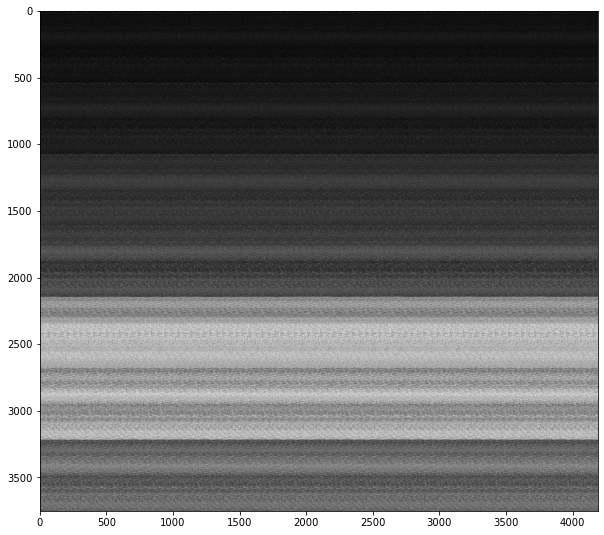

In [33]:
result_array_t = raster_array_table.transpose()
print(result_array_t.shape)

result_array = result_array_t.reshape(raster_array_t.shape[2], raster_array_t.shape[1], raster_array_t.shape[0])
print(result_array.shape)

Result_Check = np.dstack((scaleCCMinMax(result_array[:, :, 3]), scaleCCMinMax(result_array[:, :, 2]), scaleCCMinMax(result_array[:, :, 3])))

plt.figure(figsize=(10, 10))
plt.imshow(Result_Check)
# plt.savefig('../results/Image_Pre_Check.png')
plt.show()

(15709188, 1)
(3751, 4188)


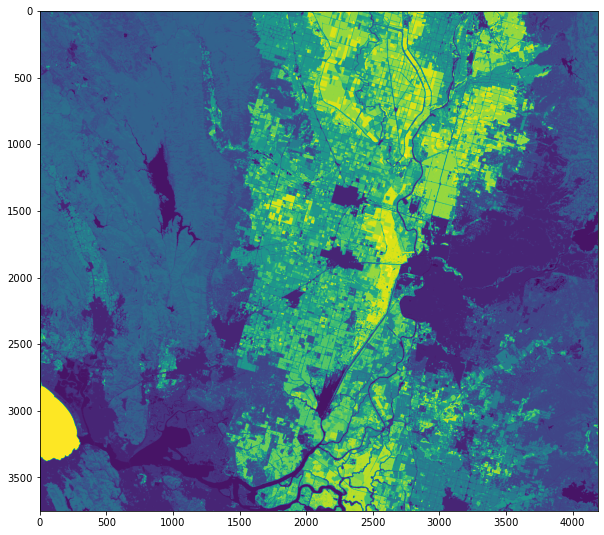

In [24]:
print(groundTruth_table.shape)
groundTruth_table = np.asarray(groundTruth_table)
groundTruth_s = groundTruth_table.transpose().reshape(groundTruth.shape[0], groundTruth.shape[1])
print(groundTruth_s.shape)

plt.figure(figsize=(10, 10))
plt.imshow(groundTruth_s)
plt.show()

(15709188,)
(3751, 4188)


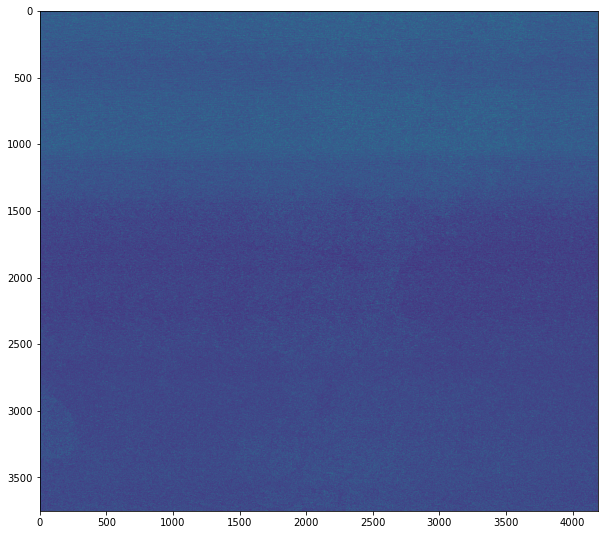

In [25]:
print(pred_rfc.shape)

prediction_rfc = pred_rfc.transpose().reshape(groundTruth.shape[0], groundTruth.shape[1])
print(prediction_rfc.shape)

plt.figure(figsize=(10, 10))
plt.imshow(prediction_rfc)
plt.show()

(15709188,)
(3751, 4188)


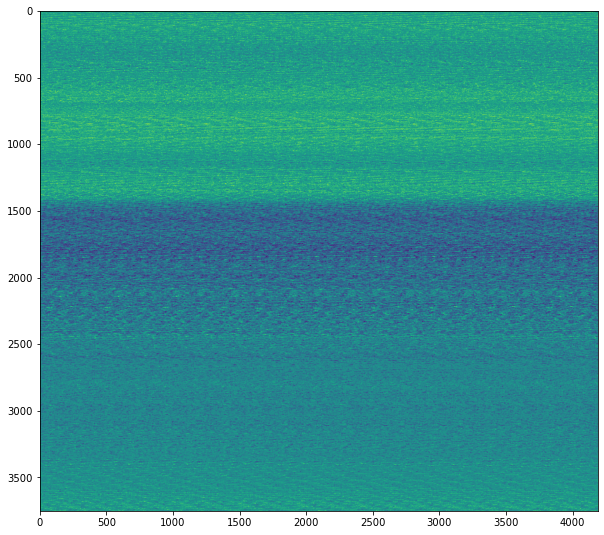

In [26]:
print(pred_clf.shape)

prediction_clf = pred_clf.transpose().reshape(groundTruth.shape[0], groundTruth.shape[1])
print(prediction_clf.shape)

plt.figure(figsize=(10, 10))
plt.imshow(prediction_clf)
plt.show()

In [43]:
# class_labels = ['Background', 'Barren', 'Water', 'Urban', 'Wetland', 'Grassland', 'Hay', 'Shrubland', 'Forest', 'Grapes', 'FruitsTree', 'NutTree', 'GroundVege', 'Tuber', 'Alfalfa', 'Flower', 'Wheat', 'Rice', 'Corn', 'Idle cropland', 'Other Crops']
# colors = ['black', 'brown', 'blue', 'purple', 'cyan', 'lime', 'gold', 'green', 'forestgreen', 'seagreen', 'limegreen', 'lawngreen', 'yellowgreen', 'goldenrod', 'springgreen', 'red', 'oragne', 'tomato', 'darkorange', 'peru', 'grey']

# cmap = ListedColormap(colors)

# class_bins = [.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5]
# norm = BoundaryNorm(class_bins, len(colors))

# xr.DataArray(prediction, coords=da.coords, dims=da.dims, attrs=da.attrs)

# f, ax = plt.subplots(figsize=(16, 16))
# im = prediction.plot.imshow(cmap=cmap, norm=norm, add_colorbar=False)

# # ep.draw_legend(im, titles=height_class_labels)
# ax.set(title="Classified Lidar Canopy Height Model \n Derived from NEON AOP Data")
# ax.set_axis_off()
# plt.show()

# C:\Users\YunzZhu\.conda\envs\rangeland\python.exe -I"C:\Users\YunzZhu\.conda\envs\rangeland\Library\include\gdal.h" -lgdal_i -L"C:\Users\YunzZhu\.conda\envs\rangeland\Library\lib\gdal_i.lib" install GDAL-3.0.2-py3.9-win-amd64.egg-info

In [ ]:
# fig, ax = plt.subplots(figsize=(16, 16))

# chm_plot = ax.imshow(lidar_chm,
#                      cmap=cmap,
#                      norm=norm)

# ax.set_title("Lidar Canopy Height Model (CHM)")

# # Add a legend for labels
# legend_labels = {"tan": "short", 
#                  "springgreen": "medium", 
#                  "darkgreen": "tall"}

# patches = [Patch(color=color, label=label)
#            for color, label in legend_labels.items()]

# ax.legend(handles=patches,
#           bbox_to_anchor=(1.35, 1),
#           facecolor="white")

# ax.set_axis_off()
# plt.show()